# Long-run identificaiton

<a id='tc'></a>
## Table of content

**PART I** - [Setup](#setup)
1. [imports](#imports)
2. [helpers](#helpers)
3. [evaluate function](#evaluate)
4. [build per action capture model](#build-per-action-capture-model)

2. [sliding time window](#stw)
    1. [implementation](#implementation_stw)
    2. [Training](#evaluation_stw)
        - No training, output simply majority voting
        - Train on per-action capture: perform data augmentation (cut corp the data) labeled as 1. etc...and use NoApp NoAction labeled as 0 (maybe use same model as )
        - Train on longrun capture with probabilities output


<a id='setup'></a>
## PART I - Setup
[table of content](#tc)
<a id='imports'></a>

In [1]:
# imports
import pandas as pd
import numpy as np
import sys
import random
from build_datasets import *
import csv
import os
import pickle
import copy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import shuffle

<a id='helpers'></a>
## Helpers
[Table of Content](#tc)

#### imports

In [2]:
### Capture time serie

all_columns = set()
def extract_columns(dataset_file):
    all_columns = set()

    with open(dataset_file, "r") as file:
        csv_reader = csv.reader(file, delimiter=',', quotechar='"')
        for i, line in enumerate(csv_reader):
            all_columns.update(line)
            return all_columns


def new_packet(columns):
    packet = dict()
    for column in columns:
        packet[column] = ""

    return packet


def read_file(dataset_file, columns):
    """
    Reads a .csv file and puts its raw contents in packet_store[dataset_file]
    """
    ID_COLUMN = "Packet #"
    dataset_packet_store = dict() # packetID => packets
    headers = []
    with open(dataset_file, "r") as file:
        reader = csv.reader(file, delimiter=',', quotechar='"')

        for i, line in enumerate(reader):
            if i == 0:
                headers = line
                continue

            packet = new_packet(columns)

            for j, item in enumerate(line):
                key = headers[j]
                val = item

                if key not in packet:
                    print(packet)
                    print("Fatal: column '{}' not found in packet; all_columns is {}".format(key, columns))
                    sys.exit(1)
                packet[key] = val

            packet_id = toInt(packet[ID_COLUMN].replace('\'', ''))
            if packet_id not in dataset_packet_store:
                dataset_packet_store[packet_id] = []

            dataset_packet_store[packet_id].append(packet)

    return dataset_packet_store


def extract_payload_length(payload_string, default=0):
    payload_string = payload_string.strip()
    if payload_string == "" or "No data" in payload_string:
        return default
    parts = payload_string.split(' ')
    return toInt(parts[0])


def packet_store_cleanup(packets): #dataset_packet_store is packetID => packets
    for packet_id in packets:
        layers = packets[packet_id]
        for layer in layers:
            layer[ID_COLUMN] = toInt(layer[ID_COLUMN])
            layer["Time"] = toFloat(layer["Time"], default=-1)
            layer["Time delta"] = toFloat(layer["Time delta"], default=-1)
            layer["PayloadLength"] = extract_payload_length(layer["Payload"], default=0)
            layer["PayloadRaw"] = extract_payload_bytes(layer["Payload"])
    return packets


def packets_to_timesize_tuples(packets):
    global master
    xy = dict(xs=[], ys=[])
    packets_ids = list(packets.keys())
    packets_ids.sort(reverse=False)

    # Ensure that the direction stays the same even if HUAWEI Watch becomes master


    for packet_id in packets_ids:
        for layer in packets[packet_id]:
            master = extract_master(layer["Communication"])
            if master in POSSIBLE_MASTERS:
                direction = 1
            else:
                print("WARNING master not in Possible masters: '" + master + "'")
                print(layer["Communication"])
                direction = -1

            if not "master" in layer['Transmitter'].lower():
                direction *= -1
            xy['xs'].append(float(layer['Time']))
            xy['ys'].append(direction * int(layer['PayloadLength']))
    return xy


def merge_actions_in_app(events, to_merge):
    for actions in to_merge:
        events = merge_action_in_app(events, actions)
    return events


def merge_action_in_app(events, to_merge, separate_watch=True, maximum_level=None): # TODO separate watch
    """to_merge is of the form [app_feature_x1, app_feature_x2...]
    Cannot merge across apps
    """
    ## TODO: Make sure merge and 
    app = to_merge[0].split("_")[0]
    events_out = copy.deepcopy(events)
    to_merge_action_set = set([f.split("_")[1] for f in to_merge])
    print("to_merge_action_set = ", to_merge_action_set)
    for w in events:
        for appli in events[w]:
            if appli != app:
                continue
            merged_actions = []
            labeled_actions = ""
            for action in events[w][app]:
                if action in to_merge_action_set:
                    labeled_actions += action
                    merged_actions += events[w][app][action]
                    del events_out[w][app][action]
            events_out[w][app][labeled_actions] = merged_actions
    return events_out


def discard_actions(source_files, to_discard):
    sf_new = []
    for f in source_files:
        _in = False
        for df in to_discard:
            if df in f:
                _in = True
        if not _in:
            sf_new.append(f)
    return sf_new


def build_features_labels_dataset(events, adversary_capture_duration=-1, unique_from=46, unique_to=1006):
    data = []
    labels = []
    for device in events:
        for app in events[device]:
            for action in events[device][app]:
                label = app + "_" + action
                for event in events[device][app][action]:
                    features_dict = extract_features(event, adversary_capture_duration, unique_from, unique_to)
                    features = list(features_dict.values())
                    data.append(features)
                    labels.append(label)

    return data, labels



def delete_different_action_across_watch(events):
        # Create common action set if multiple watches
    intersection_set = set()
    for i, w in enumerate(events):
        all_action = []
        for app in events[w]:
            actions = set(events[w][app].keys())
            all_action += [app + "_" + act for act in actions]
        if i == 0:
            intersection_set = set(all_action)
        else:
            intersection_set = intersection_set.intersection(set(all_action))
    
    events_copy = copy.deepcopy(events)
    # Delete not common action from dictionnary
    for device in events_copy:
        for app in events_copy[device]:
            for action in events_copy[device][app]:
                if app + "_" + action not in intersection_set:
                    del events[device][app][action]
    return events


def equilibrate_events_across_apps_and_watch(events):
    """
    Equilibrate the events by identifing the minimum number of samples per class
    and discarding Randomly the extra samples present in the oder classes. 
    If there are multiple watchs, only the common application are kept

    Parameters: 
        events (dict[watch][app][action] -> event): dataset 

    Returns: 
        events (dict[watch][app][action] -> event): equilibrate dataset
    """
    
    events = delete_different_action_across_watch(events)
    
    # Find minimum samples 
    counts = dict()
    for device in events:
        for app in events[device]:
            for action in events[device][app]:
                counts[device + "_" + app +"_" + action] = 0
            for action in events[device][app]:
                counts[device + "_" + app + "_" + action] += len(events[device][app][action])

    if len(counts.values())== 0:
        return events


    nb_samples_per_cat = min(counts.values())

    events_out = dict()

    # remove everything above the min across devices
    for device in events:
        for app in events[device]:

            for action in events[device][app]:

                if not device in events_out:
                    events_out[device] = dict()
                if not app in events_out[device]:
                    events_out[device][app] = dict()
                if not action in events_out[device][app]:
                    events_out[device][app][action] = random.sample(events[device][app][action], k=nb_samples_per_cat)

    counts = dict()
    for device in events_out:
        for app in events_out[device]:
            if not app in counts:
                counts[app] = 0
            for action in events_out[device][app]:
                counts[app] += len(events_out[device][app][action])

    return events_out, nb_samples_per_cat



def extract_features(xy, capture_duration_does_nothing=0, unique_from=46, unique_to=1006): # dataset is {'xs': [packet1, packet2,...], 'ys': [packet1, packet2,...]} where x is time and y is size
    xs = xy['xs']
    ys = xy['ys']
    f = dict()

    def take(arr, n=30):
        if len(arr) > n:
            return arr[:30]
        return arr

    def stats(key, data):
        if len(data) == 0:
            data=[-1]
        f['min_'+key] = np.min(data)
        f['mean_'+key] = np.mean(data)
        f['max_'+key] = np.max(data)
        f['count_'+key] = len(data)
        f['std_'+key] = np.std(data)
        f['kurtosis_'+key] = kurtosis(data)



    # general statistics
    stats("non_null", [abs(y) for y in ys if y != 0])
    stats("outgoing", [abs(y) for y in ys if y > 0])
    stats("incoming", [abs(y) for y in ys if y < 0])
    stats("outgoing_30", [abs(y) for y in take(ys) if y > 0])
    stats("incoming_30", [abs(y) for y in take(ys) if y < 0])

    # f["total_payload"] = sum([abs(y) for y in ys])

    # statistics about timings
    x_deltas = []
    i = 1
    while i<len(xs):
        x_deltas.append(xs[i]-xs[i-1])
        i += 1

    stats("x_deltas", x_deltas)
    stats("x_deltas_30", take(x_deltas))

    # bursts

    # unique packet lengths [Liberatore and Levine; Herrmann et al.]
    lengths = dict()
    for i in range(unique_from, unique_to):
        lengths[str(i)] = 0
    for y in ys:
        if str(abs(y)) in lengths:
            lengths[str(abs(y))] += 1

    lengths_array = list(lengths.values())
    stats("unique_lengths", lengths_array)
    for l in lengths:
        f['unique_lengths_'+str(l)] = lengths[l]
        
    return f


def filter_by_length(events, minimum_payload=200, ratio_app_not_satisfing_minimum_payload_length=0.25, printInfo = False):
    results = copy.deepcopy(events)
    for watch in events:
        for app in events[watch]:
            for action in events[watch][app]:
                total_event = len(events[watch][app][action])
                bellow_minimum_payload = 0
                for sample in events[watch][app][action]:

                    payload_length = sum([abs(s) for s in sample["ys"]])
                    if payload_length < minimum_payload:
                        bellow_minimum_payload += 1

                ratio_bellow = bellow_minimum_payload / total_event
                if ratio_bellow > ratio_app_not_satisfing_minimum_payload_length:
                    if printInfo:
                        print("total_event: ", total_event, " - bellow threshold: ", bellow_minimum_payload)
                        print(app + "_" + action + " removed")
                        print(" ratio_below = ", ratio_bellow)
                    del results[watch][app][action]

            if len(results[watch][app]) == 0:
                del results[watch][app]
    return results



def count_print(events):
    for d in events:
        for app in events[d]:
            for act in events[d][app]:
                print("{}: {}_{} - {}".format(d, app, act,  len(events[d][app][act])))

                
# Compute the mean over realisations
def plot_acc_and_conf(n_samples, accuracies, repeat, title, xlabel, ylabel, fname, y_lim=None, RETURN_ACC=False, dpi=500):
    n_samples = np.array(n_samples)
    accuracies = np.array(accuracies)


    n_samples_repr = n_samples.reshape((-1,repeat))[:,0]
    accuracies_repr = accuracies.reshape((-1,repeat)) * 100

    accuracies_avg = accuracies.reshape((-1,repeat)).mean(axis = 1)
    if RETURN_ACC:
        return n_samples_repr, accuracies_avg
    
    accuracies_conf = accuracies.reshape((-1,repeat)).std(axis = 1) * 2 

    conf_upper = accuracies_avg + accuracies_conf
    conf_lower = accuracies_avg - accuracies_conf

    fig, ax = plt.subplots()
    ax.plot(n_samples_repr, accuracies_avg, '-b', label='averaged accuracy')
    ax.plot(n_samples_repr, conf_upper, '--r', label='95% confidence interval')
    ax.plot(n_samples_repr, conf_lower, '--r')
    plt.title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if y_lim is not None:
        plt.ylim(y_lim[0], y_lim[1])
    leg = ax.legend()
    plt.savefig("./"+fname, dpi=dpi)

    
    
def extract_features(xy, capture_duration_does_nothing=0, unique_from=46, unique_to=1006): # dataset is {'xs': [packet1, packet2,...], 'ys': [packet1, packet2,...]} where x is time and y is size
    xs = xy['xs']
    ys = xy['ys']
    f = dict()

    def take(arr, n=30):
        if len(arr) > n:
            return arr[:30]
        return arr

    def stats(key, data):
        if len(data) == 0:
            data=[-1]
        f['min_'+key] = np.min(data)
        f['mean_'+key] = np.mean(data)
        f['max_'+key] = np.max(data)
        f['count_'+key] = len(data)
        f['std_'+key] = np.std(data)
        f['kurtosis_'+key] = kurtosis(data)



    # general statistics
    stats("non_null", [abs(y) for y in ys if y != 0])
    stats("outgoing", [abs(y) for y in ys if y > 0])
    stats("incoming", [abs(y) for y in ys if y < 0])
    stats("outgoing_30", [abs(y) for y in take(ys) if y > 0])
    stats("incoming_30", [abs(y) for y in take(ys) if y < 0])

    # f["total_payload"] = sum([abs(y) for y in ys])

    # statistics about timings
    x_deltas = []
    i = 1
    while i<len(xs):
        x_deltas.append(xs[i]-xs[i-1])
        i += 1

    stats("x_deltas", x_deltas)
    stats("x_deltas_30", take(x_deltas))

    # bursts

    # unique packet lengths [Liberatore and Levine; Herrmann et al.]
    lengths = dict()
    for i in range(unique_from, unique_to):
        lengths[str(i)] = 0
    for y in ys:
        if str(abs(y)) in lengths:
            lengths[str(abs(y))] += 1

    lengths_array = list(lengths.values())
    stats("unique_lengths", lengths_array)
    for l in lengths:
        f['unique_lengths_'+str(l)] = lengths[l]
        
    return f

def get_all_actions(events):
    all_actions = set()
    for d in events:
        for app in events[d]:
            for act in events[d][app]:
                all_actions.add(app+"_"+act)
    return all_actions

##### Longrun Capture related

In [3]:
# Imports 


## Build bounds for groundtruth

## 

<a id="evaluate"></a>
### Evaluate
[Table of Content](#tc)


In [4]:
def evaluate(DATA_PATH, DISCARDED_ACTION=[], TO_MERGE=[], EQUALIZATION=True,
             REBUILD=False, TEST_PERCENTAGE=0.25, MINIMUM_PAYLOAD=200, SHUFFLE=False,
             RATIO=0.25, N_SPLITS=50, N_ESTIMATOR=100, SEPARATE_WATCH=False,
             PRINT_COUNT=False, PLOT_DIR="./plots/", RETURN_PRED=False, RETURN_FILTIRED=False,
             RETURN_EQUILIBRATE_EVENTS=False, RETURN_FEATURES_AND_LABELS=False):
    
    print("\nimporting data...")
    sources_files = find_sources(DATA_PATH)


    if len(DISCARDED_ACTION) != 0:
        print("withdraw action to be discarded")
        sources_files = discard_actions(sources_files, DISCARDED_ACTION)


    if REBUILD:
        print("rebuilding dataset")
        rebuild_all_datasets(sources_files)

    events, counts = cut_all_datasets_in_events(sources_files)

    if len(TO_MERGE) != 0:
        print("merging events")
        events = merge_actions_in_app(events, TO_MERGE)


    print("filtering app that does not send traffic by their length")
    filtered_events = filter_by_length(events, minimum_payload=MINIMUM_PAYLOAD, ratio_app_not_satisfing_minimum_payload_length=RATIO)
    
    if RETURN_FILTIRED:
        return filtered_events
    
    if PRINT_COUNT:
        print("\nclass event count")
        count_print(filtered_events)
        print()

    nb_samples_per_cat = "not uniform"
    if EQUALIZATION:
        print("dataset equalization per class")
        filtered_events, nb_samples_per_cat = equilibrate_events_across_apps_and_watch(filtered_events)
        
        if PRINT_COUNT:
            print("\nclass event count after equalization")
            count_print(filtered_events)
            print()
        if RETURN_EQUILIBRATE_EVENTS:
            return filtered_events
    
    if SEPARATE_WATCH:
        print("separate watch action")
        filtered_events = separate_watch(filtered_events)
        if PRINT_COUNT:
            print()
            count_print(filtered_events)


    print("building features and labels")
    X, y = build_features_labels_dataset(filtered_events)
    if RETURN_FEATURES_AND_LABELS:
        return X, y

    # ## Accuracy with cross validation

    print("building and training the model for cross validation ")
    clf=RandomForestClassifier(n_estimators=N_ESTIMATOR, random_state=None)
    shuf_split = ShuffleSplit(n_splits=N_SPLITS, test_size=0.25, random_state=None)
    scores_shuffle = cross_val_score(clf, X, y, cv=shuf_split)
    print("Random split cross-validation: Accuracy=%0.3f (+/- %0.2f). " % (scores_shuffle.mean(), scores_shuffle.std() * 2))
    eval_metric = "cross-val radomSplit={} accRs={:.1f} +-{:.1f}% 95% conf interval".format(N_SPLITS, scores_shuffle.mean() *100, scores_shuffle.std() * 2 * 100)

    # ### Plotting the confusion matrix

    print("building and training a model for confusion matrix")
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=None)


    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if RETURN_PRED:
        return y_test, y_pred
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("accuracy = ", accuracy)


    title = "Confusion matrix for {}acc={:0.2f} ".format("and ".join([f.replace("/", "_") for f in DATA_PATH]), accuracy * 100)
    title += eval_metric
    title += "test={}% minimum_payload={}B nb_samples={}".format(int(TEST_PERCENTAGE * 100), MINIMUM_PAYLOAD, nb_samples_per_cat)
    saved_title = title.replace(".", "_").replace(" ", "_")
    cm, _, _ = plot_confusion_matrix(y_test, y_pred, title= title, save = saved_title, PLOT_DIR=PLOT_DIR)
    
    return cm 
    print("done")

<a id='build-per-action-capture-model'></a>
## Preparation

### Build per action capture model
[Table of Content](#tc)

In [72]:
# Choose the data to be included in the model
DATA_PATH = ["data/huawei/Endomondo-1/", "data/huawei/AppInTheAir-1/", "data/huawei/force-stop/", 
             "data/huawei/DiabetesM-2/", "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/",
             "data/huawei/FoursquareCityGuide-1/", "data/huawei/HealthyRecipes-1/",
             "data/huawei/Lifesum-1/", "data/huawei/Playstore-1/", "data/huawei/open-6/"]

# Discard:  'FitBreathe_open','FitWorkout_open','Fit_open'. Because of update does not send data anymore
DISCARDED_ACTION = [ 'FitBreathe_open', 'FitWorkout_open', 'Fit_open']

# Extract features 
X, y = evaluate(DATA_PATH, RETURN_FEATURES_AND_LABELS=True, DISCARDED_ACTION=DISCARDED_ACTION)

# Create and Train the model
clf=RandomForestClassifier(n_estimators=200, random_state=None)
clf.fit(X, y)

# Get the set of all classes the classifier knows about
events = evaluate(DATA_PATH, RETURN_FILTIRED=True)
all_actions = get_all_actions(events)


importing data...
withdraw action to be discarded
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels

importing data...
filtering app that does not send traffic by their length


<a id='convert-longrun'></a>
### Import data, ground-truth and checked ground-truth
[Table of Content](#tc)


- ***Data*** refers to the actual longrun captures 

- ***Ground-truth*** refers to the metadata that comes automatically with the longrun capture. It is a log file and contains information about which and when an action is performed since the capture's launch

- ***Checked ground-truth*** refers to the manually checked ground-thruth. (Used to measure the discrepancy of the automation vs the manual checked. This discrepency is due to a delay between sending the command to performing an action and the actual traffic generated by this action).


#### Compute lower and upper bound of ground_truth using checked ground-truth

Estimating delay between groundtruth and checked ground-truth (boundaries)

In [73]:
def filter_out_path(fs, filter_out_device = False):
    f = fs[fs.rfind('/')+ 1:]
    if filter_out_device:
        f = f[f.rfind('_')+ 1:]
    return f


# Finds datasets recursively
def find_sources(folders='./'):

    if type(folders) is not list:
        folders = [folders]

    sources_files = []

    for folder in folders:
        files = glob.glob(folder + '*.csv', recursive=True)
        for file in files:
            ignore = False
            for ignore_pattern in SOURCES_FILE_IGNORE:
                if ignore_pattern in file:
                    ignore = True
            if not ignore:
                sources_files.append(file.replace('./', ''))

    return sorted(sources_files)


def extract_fname(f):
    "Extract the name of a file (filter out the path and the extention.)"
    return filter_out_path(f[:f.rfind(".")])


def read_longrun_log_file(longrunLogFile, all_action=None):
    """
    Args: 
        longrunLogFile : File log name (including path)
        all_action : actions used to train the model (needed to filter out actions not part of the training set)
    
    Return
        [[time, action],] : filtered and clean version of the content of a logfile
    """
    out = []
    with open(longrunLogFile, "r") as file:
        csv_reader = csv.reader(file, delimiter=',', skipinitialspace=True)
        next(csv_reader)
        for i, line in enumerate(csv_reader):
            if all_action is None or line[1] in all_action:
                out.append(line)
    return out
            

def read_longrun_log_files(longrunLogFiles, all_action=None):
    """
    Args: 
        longrunLogFiles : a list of files log names (including path)
        all_action : actions used to train the model (needed to filter out actions not part of the training set)
    
    Return
        dict[filename] = [[time, action],] : filtered and clean version of the content of multiple logfile
    """
    out = dict()
    for longrunLogFile in longrunLogFiles:
        out[extract_fname(longrunLogFile)] = read_longrun_log_file(longrunLogFile, all_action)
    return out

In [74]:
def intersection_fname(files1, files2, print_missing=True):
    "Return the list of files names (without extension) that files1 containes and files2 contains"
    if len(files1) == 0 or len(files2) == 0:
        print("WARNING: one or both dir. are empty")
        return []

    extension1 = files1[0][files1[0].rfind("."):]
    extension2 = files2[0][files2[0].rfind("."):]

    files1_filtered = set()
    files2_filtered = set()
    
    for f1 in files1:
        files1_filtered.add(extract_fname(f1))
    for f2 in files2:
        files2_filtered.add(extract_fname(f2))
    
    complete_files = files1_filtered.intersection(files2_filtered)
    missing_files = sorted(list(files1_filtered.union(files2_filtered) - complete_files))

    # print Missing files
    if print_missing:
        for mf in missing_files:
            if mf in files1_filtered:
                print("WARNING: {} - {} companion missing".format(mf, extension2))
            if mf in files2_filtered:
                print("WARNING: {} - {} companion missing".format(mf, extension1))
    return sorted(list(complete_files))


def record_diff_checked_gt(checkeds, gts, all_actions):
    """
    Aggregate and filter the recordings timing difference between checked and ground-truth for one file
    Args:
        checkeds: [[t, action],]. The manullay checked ground truth content
        gts: [[t,action],]. The generated ground truth content 
        all_actions: [action,]. List of actions that are part of the training set. (Use as a filter).
    Return:
        recording: [diff,]. List of int representing the delay between ground truth and checked ground truth.
    """
    recordings = []
    for checked, gt in zip(checkeds, gts):
        action = gt[1]
        if action is None:
            print("ERROR: Parsing failure")
            break
        if eval(checked[0]) is None or action not in all_actions:
            continue

        recordings.append(float(checked[0]) - float(gt[0]))  # add the difference between 
    return recordings


def record_diff_checked_gts(content_ground_truth_for_boundaries, content_checked_for_boundaries, all_actions):
    """
    Aggregate and filter the recordings timing difference between checked and ground-truth accross all files.
    Args: 
        content_ground_truth_for_boundaries: fileName -> [[t, action],]. Dict of the generated ground truth content.
        content_checked_for_boundaries: fileName -> [[action, t],]. Dict of the manullay checked ground truth content
        all_actions: [action,]. List of actions that are part of the training set. (Use as a filter).
        
    Return:
        recording: [diff,]. List of int representing the delay between ground truth and checked ground truth.
    """
    recordings = []

    for capt in content_checked_for_boundaries:
        checkeds = content_checked_for_boundaries[capt]
        gts = content_ground_truth_for_boundaries[capt]
        recordings += record_diff_checked_gt(checkeds, gts, all_actions)
    return recordings


def make_bound_for_timing_in_action(content_ground_truth, lower, upper):
    """
    Make time boundaries for each action. 
    Args:
        content_ground_truth: fileName -> [[t, action],]. Dict of the generated ground truth content.
        lower: lower bound of the first seen traffic emanetaed from a perormed aciton
        upper: upper bound of the first seen traffic emanetaed from a perormed aciton
    Return:
        content_ground_truth_with_bound: fileName -> [[(t_lower, t_upper), action],]. Ground truth with time bounded actions
    """
    content_ground_truth_with_bound = dict()
    for gt in content_ground_truth:
        new_gt = []
        for i, action in content_ground_truth[gt]:
            lower_bound = float(i) + lower
            upper_bound = float(i) + upper
            new_gt.append((lower_bound, upper_bound, action))
        content_ground_truth_with_bound[gt] = new_gt
    return content_ground_truth_with_bound


In [75]:

# Compute Lower and Upper bound of the ground truth using checked ground truth.
GROUND_TRUTH_PATH_FOR_BOUNDARIES = "./data/huawei/longrun/deterministic-15min-1/ground-truth/"
CHECKED_GT_PATH_FOR_BOUNDARIES = "./data/huawei/longrun/deterministic-15min-1/checked-gt/"

gt_path_content_for_boundaries = sorted(glob.glob(GROUND_TRUTH_PATH_FOR_BOUNDARIES + '*.log', recursive=True))
checked_gt_path_content_for_boundaries = sorted(glob.glob(CHECKED_GT_PATH_FOR_BOUNDARIES + '*.log', recursive=True))

# All checkeds that can be used must have their .log companion (in ground-truth)
checked_files = intersection_fname(gt_path_content_for_boundaries, checked_gt_path_content_for_boundaries, print_missing=False)

path_files_ground_truth_for_boundaries = [GROUND_TRUTH_PATH_FOR_BOUNDARIES + f + ".log" for f in checked_files]
path_files_checked_for_boundaries = [CHECKED_GT_PATH_FOR_BOUNDARIES + f + ".log" for f in checked_files]

content_ground_truth_for_boundaries = read_longrun_log_files(path_files_ground_truth_for_boundaries, all_actions)
content_checked_for_boundaries = read_longrun_log_files(path_files_checked_for_boundaries, all_actions)

recordings = record_diff_checked_gts(content_ground_truth_for_boundaries, content_checked_for_boundaries, all_actions)


print("Discrepency between automate and manually checked gournd-truth for action launch time differece:\n")
print("   mean_diff = {}\n   max_diff={}\n   min_diff={}\n".format(np.mean(recordings), np.max(recordings), np.min(recordings)))
margin_timing_difference = 2
upper = np.max(np.array(recordings)) + margin_timing_difference
lower =  np.min(np.array(recordings)) - margin_timing_difference
print(" adapting correct new bound with lower = {}, upper = {}".format(lower, upper))


Discrepency between automate and manually checked gournd-truth for action launch time differece:

   mean_diff = 5.078723404255315
   max_diff=16.5
   min_diff=0.39999999999997726

 adapting correct new bound with lower = -1.6000000000000227, upper = 18.5


## Data importation
<a id='stw'></a>

In [184]:
DATA_PATH = "./data/huawei/longrun/deterministic-20min-1/"
GROUND_TRUTH_PATH = DATA_PATH + "ground-truth/"

data_path_content = sorted(glob.glob(DATA_PATH + '*.csv', recursive=True))
gt_path_content = sorted(glob.glob(GROUND_TRUTH_PATH + '*.log', recursive=True))


# All data that can be used must have their .log companion (in ground-truth)
ready_dataset = intersection_fname(data_path_content, gt_path_content)

path_files_data = [DATA_PATH + f + ".csv" for f in ready_dataset]
path_files_ground_truth = [GROUND_TRUTH_PATH + f + ".log" for f in ready_dataset]

# Read ground_truth and make boundaries
content_ground_truth = read_longrun_log_files(path_files_ground_truth, all_actions)
content_ground_truth = make_bound_for_timing_in_action(content_ground_truth, lower, upper)


In [185]:
data_path_content

['./data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_17-07-11.csv',
 './data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_17-28-27.csv',
 './data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_17-49-13.csv',
 './data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_18-09-59.csv',
 './data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_18-30-44.csv',
 './data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_18-51-28.csv',
 './data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_19-21-35.csv',
 './data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_19-43-00.csv',
 './data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_20-04-02.csv',
 './data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_20-24-54.csv',
 './data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_20-

In [186]:
# From files to time series
captures = dict()
for longrunCaptFile in data_path_content:
    print(longrunCaptFile)
    columns = extract_columns(longrunCaptFile)
    packets = read_file(longrunCaptFile, columns)
    packets = packet_store_cleanup(packets)
    time_serie = packets_to_timesize_tuples(packets)
    captures[extract_fname(longrunCaptFile)] = time_serie

./data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_17-07-11.csv
./data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_17-28-27.csv
./data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_17-49-13.csv
./data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_18-09-59.csv
./data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_18-30-44.csv
./data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_18-51-28.csv
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "

WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-

Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in Possible masters: 'Inquirer'
Master: "Inquirer"  <-> Slave: "Inquiry Listeners" 
WARNING master not in

./data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_19-43-00.csv
./data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_20-04-02.csv
./data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_20-24-54.csv
./data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_20-45-46.csv
./data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_21-06-37.csv
./data/huawei/longrun/deterministic-20min-1/longrun_deterministic_20-04-12_21-27-29.csv
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Pos

WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5

WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5

Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not 

Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not 

WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5

WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5

WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5

Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not 

WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5

Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not in Possible masters: 'HUAWEI WATCH 2 1857'
Master: "HUAWEI WATCH 2 1857" E4:34:93:59:A5:9E <-> Slave: "Pixel 2" 40:4E:36:DE:1C:8F
WARNING master not 

<a id='stw'></a>
## Sliding Time Window
[table of content](#tc)

Adventage: does not need supervision for the data

Idea to improve: Take the noApp noAcction > 200KB and train a model to predict noise

Preprocessing: Remove
for each 5


### Helpers

In [187]:
def find_critical_point(time_serie):
    # find Critcal points: where we have more than 2k data
    ts = pd.Series(data = time_serie['ys'], index = pd.to_timedelta(time_serie["xs"], 'sec'))

    # filter out packets with no payload length and (or not) the ones that contains < 26 bits
    ts = ts.map(abs)[ts != 0] #[ts > 26]

    def time_delta_to_float(td):
        if len(td) == 0:
            return None
        return float(str(td[0].seconds) +"." + str(td[0].microseconds))

    # Compute the moving average of 30 seconds head in data PayloadLength

    stw = ts[::-1].rolling("20s").sum()[::-1]
    stw = stw[stw > 200]  # filter out minimum 200B payload (banned app)


    stw = stw.resample('5s').apply(lambda x: x.index) # 5 seconds jump
    critical_points = stw.map(time_delta_to_float).dropna().values

<a id='implementation_stw'></a>
## Implementation
[Table of Content](#tc)

### Helpers

In [188]:
def find_critical_point(time_serie):
    # find Critcal points: where we have more than 2k data
    ts = pd.Series(data = time_serie['ys'], index = pd.to_timedelta(time_serie["xs"], 'sec'))

    # filter out packets with no payload length and (or not) the ones that contains < 26 bits
    ts = ts.map(abs)[ts != 0] #[ts > 26]
    
    
    def extract_indexes_in_groups(x):
        return x.index.tolist()
    
    def time_delta_to_float(td):
        if len(td) == 0:
            return None
        return float(str(td[0].seconds) +"." + str(td[0].microseconds))

    # Compute the moving average of 30 seconds head in data PayloadLength

    stw = ts[::-1].rolling("20s").sum()[::-1]
    stw = stw[stw > 200]  # filter out minimum 200B payload (banned app)


    stw = stw.resample('5s').apply(extract_indexes_in_groups) # 5 seconds jump
    
    
    critical_points = stw.map(time_delta_to_float).dropna().values
    return critical_points



def find_action_end(xs_capt, ys_capt, FILTER_LENGTH_LIMIT=46 ,INTER_TIMER_EVENT_CUTOFF=5):
    """
    return the potential end of the action that begins at indicce j
    xs_capt : time elements
    ys_capt : length elements
    FILTER_LENGTH_LIMIT : do not take length <= n
    INTER_TIMER_EVENT_CUTOFF ; Do not take into accout 
    
    return indices of the en
    """
    xs_no_zeros = [x  for y, x in zip(ys_capt, xs_capt) if abs(y) > FILTER_LENGTH_LIMIT]
    for i, x0 in enumerate(xs_no_zeros):
        if i + 1 == len(xs_no_zeros):
            return xs_capt[-1]  # reached the end
        x1 = xs_no_zeros[i + 1]
        inter_time = x1-x0
        if inter_time > INTER_TIMER_EVENT_CUTOFF:
            return x0
        
def find_x_indices(xs_capt, j, xs_end):
    for i, x in enumerate(xs_capt[j:]):
        if xs_end <= x:
            return i + j

### Prediction

In [189]:
def predict(time_serie):
    critical_points = find_critical_point(time_serie)


    predicted = []  # tuple list of 
    critical_points_i = 0
    xs_end = -1
    xs_capt = time_serie["xs"]
    ys_capt = time_serie["ys"]



    for i, _ in enumerate(xs_capt):


        current_xs = xs_capt[i]
        critical_point = critical_points[critical_points_i]
        if current_xs > critical_point and current_xs > xs_end:

            j = i-1   # take previous one since we are one step further

            xs_start = xs_capt[i]
            xs_end = find_action_end(xs_capt[i:], ys_capt[i:])
            end_indice = find_x_indices(xs_capt, j, xs_end)
            xy = dict()
            xy["xs"] = xs_capt[j:end_indice+1]
            xy["ys"] = ys_capt[j:end_indice+1]
            features_dict = extract_features(xy)
            features = list(features_dict.values())
            y = clf.predict_proba(np.array(features).reshape(1,-1))
            
            predicted.append((xs_start, xs_end, y[0]))

            while critical_points[critical_points_i] < xs_end:
                critical_points_i +=1
                if critical_points_i == len(critical_points):
                    break




        if critical_points_i == len(critical_points) or xs_end == xs_capt[-1]:
            break
    return predicted

In [190]:
predicted = dict()
for capture in captures:
    print(capture)
    predicted[capture] = predict(captures[capture])


longrun_deterministic_20-04-12_17-07-11
longrun_deterministic_20-04-12_17-28-27
longrun_deterministic_20-04-12_17-49-13
longrun_deterministic_20-04-12_18-09-59
longrun_deterministic_20-04-12_18-30-44
longrun_deterministic_20-04-12_18-51-28
longrun_deterministic_20-04-12_19-21-35
longrun_deterministic_20-04-12_19-43-00
longrun_deterministic_20-04-12_20-04-02
longrun_deterministic_20-04-12_20-24-54
longrun_deterministic_20-04-12_20-45-46
longrun_deterministic_20-04-12_21-06-37
longrun_deterministic_20-04-12_21-27-29


### Evaluation metrics: 



To evaluate the system, we first defined the following:

- TP: stands for True Positive. In our case, TP is defined as the number of **correct prediction**. The prediction for a particular time match the action performed on the watch at this time.

- FP: stands for False Positive. FP is defined by the number of **wrong prediction** The prediction for a particular time does not match the action performed on the watch at this time or there is no performed action at this time.

- FN: stands for False Negative. FN is defined as the number of **missed performed action**. Actions that was in the ground_thruth log file but we  

***Precision*** :
   The Precision can be computed by the following formula:
   $$\frac{TP}{TP + FP}$$
   
   This quantity represents the fraction of time a prediction is correct regardless of rather there is no associated action at that time or the action is not the one predicted.


 
***Recall***:
    The recall can be computed by the following formula:
    $$\frac{TP}{TP + FN}$$
    
   This quantity represents the fraction of time actions performed on the smartwatch are corrected classified. (fraction of time we have a correct prediciton match in time and in label for a performed action)
    

In [191]:
def overlaps(a, b):
    return not (b[0] > a[1] or a[0] > b[1])


def overlap_length(a,b):
    if not overlaps(a, b):
        return 0
    return  min(a[1], b[1]) - max(a[0], b[0])


def majority_voting(pred_vec):
    return clf.classes_[np.argmax(pred_vec)]


def top_n_majority_voting(pred_vec):
    top_args = np.argsort(-pred_vec)[:TOP_N].tolist()
    return [clf.classes_[top_arg] for top_arg in top_args]


def compute_eval_metric(prediciton, ground_truth, method="majority_voting", TOP_N=3, print_details=True):
    """
    calculate accuarcy, precision and recall 
    Args:
        prediction : [(start, stop, action),]. List of predicition with time boundaries
        ground_truth : [(start, stop, action),]. List of ground_turh associated with the prediction
        methods : str. The method to use to classify the probability output. 
                       The list of possible methods are the folowing:
                       'majority_voting', 'top_n_majority_voting'
    Return (tp, fp, fn) True Positive, False Positive and False Negative
    """
    tp, fp, fn = 0, 0, 0
    i_pred, i_gt = 0, 0
    correct_pred, wrong_pred, missed_gt, correct_gt = [], [], [], []
    last_run = False
    
    
    def add_wrong_pred(pred, fp):
        fp += 1
        wrong_pred.append(pred)
        if print_details:
            print(pred[2] + " wrong prediction (fp + 1= ", fp, ")")
        return fp
            
    def add_missed_gt(gt, fn):
        fn += 1
        missed_gt.append(gt)
        if print_details:
            print(gt[2], " missed prediction (fn + 1= ", fn,")")
        return fn
            
    def add_correct_pred(pred, tp):
        tp += 1
        correct_pred.append(pred)
        if print_details:
            print(pred[2] + " correct pref (tp + 1 = ", tp,")")
        return tp
    
    
    def majority_voting(pred_vec):
        return clf.classes_[np.argmax(pred_vec)]


    def top_n_majority_voting(pred_vec):
        top_args = np.argsort(-pred_vec)[:TOP_N].tolist()
        return [clf.classes_[top_arg] for top_arg in top_args]

    

    matched_pred = []
    for gt in ground_truth:
        start_gt, stop_gt, action_gt = gt
        
        match = []
        for pred in prediciton:
            start_pred, stop_pred, pred_vec = pred
            action_pred = eval(method)(pred_vec)
            # we found a match
            if overlaps((start_pred, stop_pred), (start_gt, stop_gt)) and action_gt in action_pred:
                chosen_pred = (start_pred, stop_pred, action_pred)
                match.append((chosen_pred, overlap_length((start_pred, stop_pred), (start_gt, stop_gt))))
        
        if len(match) == 0:
            fn = add_missed_gt(gt, fn)
            continue
        
        best_matchs = sorted(match,key=lambda item:-item[1]) #[0]

        for bm in best_matchs:
            pred = bm[0]
            if not pred in correct_pred:
                tp = add_correct_pred(pred, tp)
                break
        
    # compute wrong pred:
    for pred in prediciton:
        start_pred, stop_pred, pred_vec = pred
        action_pred = eval(method)(pred_vec)
        chosen_pred = (start_pred, stop_pred, action_pred)
        if chosen_pred not in correct_pred:
            fp = add_wrong_pred(chosen_pred, fp)

    return correct_pred, wrong_pred, missed_gt


### Evaluation

In [192]:
all_wrong_pred = []
all_correct_pred = []
all_missed_gt = []
for capture in captures:
    if capture == "":
        continue
    (correct_pred, wrong_pred, missed_gt) = compute_eval_metric(predicted[capture] , content_ground_truth[capture], method='majority_voting', print_details=False)
    all_wrong_pred += wrong_pred
    all_correct_pred += correct_pred
    all_missed_gt += missed_gt
    
    print(capture)
    tp, fp, fn = len(correct_pred), len(wrong_pred), len(missed_gt)
    #if tp + fp != 0 or tp + fn !=0:
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    print("precision = {}, recall = {}".format(precision, recall))
    print()

    


longrun_deterministic_20-04-12_17-07-11
precision = 0.5, recall = 0.5652173913043478

longrun_deterministic_20-04-12_17-28-27
precision = 0.6363636363636364, recall = 0.7

longrun_deterministic_20-04-12_17-49-13
precision = 0.5652173913043478, recall = 0.5652173913043478

longrun_deterministic_20-04-12_18-09-59
precision = 0.4482758620689655, recall = 0.6190476190476191

longrun_deterministic_20-04-12_18-30-44
precision = 0.4838709677419355, recall = 0.6

longrun_deterministic_20-04-12_18-51-28
precision = 0.5555555555555556, recall = 0.5769230769230769

longrun_deterministic_20-04-12_19-21-35
precision = 0.4166666666666667, recall = 0.43478260869565216

longrun_deterministic_20-04-12_19-43-00
precision = 0.3448275862068966, recall = 0.45454545454545453

longrun_deterministic_20-04-12_20-04-02
precision = 0.4166666666666667, recall = 0.5357142857142857

longrun_deterministic_20-04-12_20-24-54
precision = 0.5909090909090909, recall = 0.5416666666666666

longrun_deterministic_20-04-12_20

In [193]:

tp, fp, fn = len(all_correct_pred), len(all_wrong_pred), len(all_missed_gt)

precision = tp / (tp + fp)
recall = tp / (tp + fn)
print("precision = {}, recall = {}".format(precision, recall))
print()

precision = 0.4853801169590643, recall = 0.5478547854785478



### Deeper Analysis of the evaluation
#### Separation by action types (open, ....)

In [195]:
open_w, action_w, stop_w = 0, 0, 0

for w in all_wrong_pred:
    if 'open' in w[2]:
        open_w += 1
    elif 'force-stop' in w[2]:
        stop_w += 1
    else:
        action_w += 1


open_c, action_c, stop_c = 0, 0, 0

for c in all_correct_pred:
    if 'open' in c[2]:
        open_c += 1
    elif 'force-stop' in c[2]:
        stop_c += 1
    else:
        action_c += 1

open_m, action_m, stop_m = 0, 0, 0

for m in all_missed_gt:
    if 'open' in m[2]:
        open_m += 1
    elif 'force-stop' in m[2]:
        stop_m += 1
    else:
        action_m += 1
        

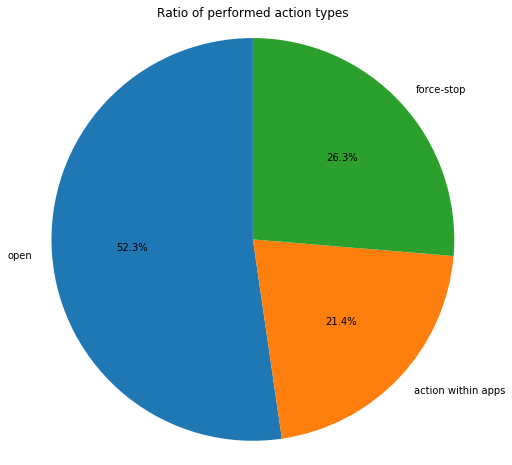

In [196]:
open_all, stop_all, action_all = (0,0,0)
for f in content_ground_truth:
    for pred in content_ground_truth[f]:
        if 'open' in pred[2]:
            open_all += 1
        elif 'force-stop' in pred[2]:
            stop_all += 1
        else:
            action_all += 1

# Plots
labels = ['open', 'action within apps', 'force-stop']
sizes = [open_all, action_all, stop_all]

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Ratio of performed action types")
plt.savefig("./plots/Ratio of performed action types".replace(" ", "_"))

plt.show()

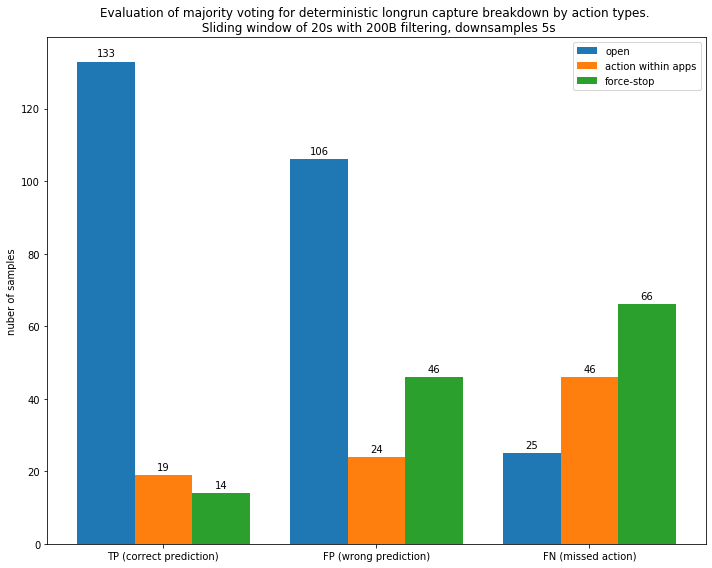

In [197]:
labels = ['TP (correct prediction)', 'FP (wrong prediction)', 'FN (missed action)']

open_vect = [open_c, open_w, open_m]
action_vect = [action_c, action_w, action_m]
force_stop_vect = [stop_c, stop_w, stop_m]

x = np.arange(len(labels))  # the label locations
width = 0.27  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width, open_vect, width, label='open')
rects2 = ax.bar(x , action_vect, width, label='action within apps')
rects3 = ax.bar(x + width, force_stop_vect, width, label='force-stop')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('nuber of samples')
ax.set_title('Evaluation of majority voting for deterministic longrun capture breakdown by action types. \n Sliding window of 20s with 200B filtering, downsamples 5s')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig("./plots/Evaluation of majority voting for deterministic longrun capture breakdown by action types".replace(" ", "_"))
plt.show()

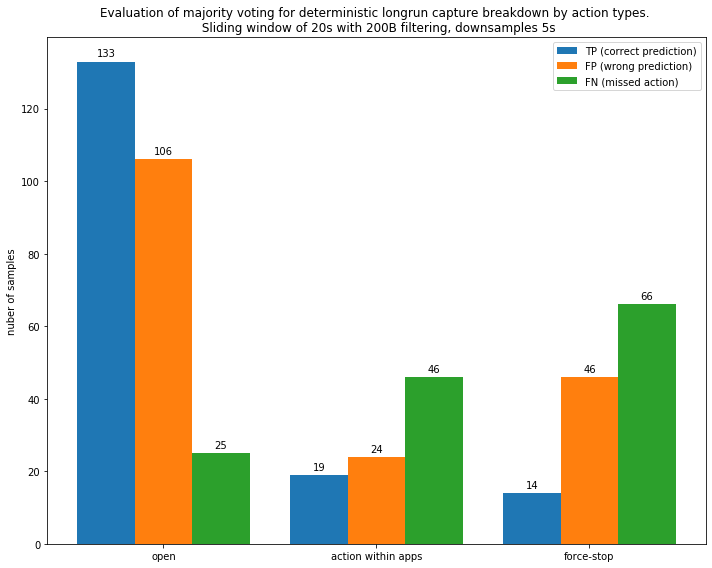

In [198]:
labels = ['TP (correct prediction)', 'FP (wrong prediction)', 'FN (missed action)']
labels = ['open', 'action within apps', 'force-stop']

tp_vect = [open_c, action_c, stop_c]
fp_vect = [open_w, action_w, stop_w]
fn_vect = [open_m, action_m, stop_m]

x = np.arange(len(labels))  # the label locations
width = 0.27  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width, tp_vect, width, label='TP (correct prediction)')
rects2 = ax.bar(x , fp_vect, width, label='FP (wrong prediction)')
rects3 = ax.bar(x + width, fn_vect, width, label='FN (missed action)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('nuber of samples')
ax.set_title('Evaluation of majority voting for deterministic longrun capture breakdown by action types. \n Sliding window of 20s with 200B filtering, downsamples 5s')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig("./plots/Evaluation of majority voting for deterministic longrun capture breakdown by action types".replace(" ", "_"))
plt.show()

Precision recall breakdown by action types

In [199]:
precision_open = open_c / (open_w + open_c)
recall_open = open_c / (open_c + open_m)

precision_stop = stop_c / (stop_w + stop_c)
recall_stop = stop_c / (stop_c + stop_m)

precision_action = action_c / (action_w + action_c)
recall_action = action_c / (action_c + action_m)

In [200]:
print("precision open = {}\nrecall open = {}\n".format(precision_open, recall_open))
print("precision stop = {}\nrecall stop = {}\n".format(precision_stop, recall_stop))
print("precision action = {}\nrecall action = {}".format(precision_action, recall_action))

precision open = 0.5564853556485355
recall open = 0.8417721518987342

precision stop = 0.23333333333333334
recall stop = 0.175

precision action = 0.4418604651162791
recall action = 0.2923076923076923


#### Breakdown by apps

In [138]:

wrong_preds = pd.Series([w[2] for w in all_wrong_pred])
correct_preds = pd.Series([c[2] for c in all_correct_pred])
missed_gts = pd.Series([m[2] for m in all_missed_gt])

In [139]:
wrong_count = wrong_preds.value_counts()
correct_count = correct_preds.value_counts()
missed_count = missed_gts.value_counts()

In [98]:
all_action_series = pd.Series([0] * len(all_actions) , list(all_actions))
correct_count = correct_count.add(all_action_series, fill_value=0).sort_values(ascending=False).astype(int)
wrong_count = wrong_count.add(all_action_series, fill_value=0).sort_values(ascending=False).astype(int)
missed_count = missed_count.add(all_action_series, fill_value=0).sort_values(ascending=False).astype(int)

In [99]:
action_not_in_dataset = correct_count[( correct_count + missed_count).fillna(0) == 0]

In [100]:
precisions = (correct_count /( correct_count + wrong_count)).fillna(0).sort_values(ascending=False)
recalls = (correct_count /( correct_count + missed_count)).fillna(0).sort_values(ascending=False)

precisions = precisions.drop(action_not_in_dataset.index)
recalls = recalls.drop(action_not_in_dataset.index)

In [102]:
# Choose the data to be included in the model
DATA_PATH = ["data/huawei/Endomondo-1/", "data/huawei/AppInTheAir-1/", "data/huawei/force-stop/", 
             "data/huawei/DiabetesM-2/", "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/",
             "data/huawei/FoursquareCityGuide-1/", "data/huawei/HealthyRecipes-1/",
             "data/huawei/Lifesum-1/", "data/huawei/Playstore-1/", "data/huawei/open-6/"]

y_true, y_pred = evaluate(DATA_PATH, RETURN_PRED=True)


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.806 (+/- 0.04). 
building and training a model for confusion matrix


#### Per_action and longrun Comparaison in one DF

In [103]:
all_actions = np.array(list(all_actions))
precision , recall, f1_score, t = precision_recall_fscore_support(y_true, y_pred, labels = all_actions)

In [104]:
model_precision = pd.Series(precision, all_actions)
model_recall = pd.Series(recall, all_actions)
model_precision = model_precision[precisions.index]
model_recall = model_recall[recalls.index]

In [105]:
total_evalution = pd.DataFrame([precisions, model_precision, recalls, model_recall], ["longrun_precision", "per_action_precision", "longrun_recall", "per_action_recall" ])
total_evaluation = total_evalution.transpose()

In [107]:
total_evaluation.head(3)

,longrun_precision,per_action_precision,longrun_recall,per_action_recall
Glide_open,1.0,1.0,0.800000,1.0
Maps_open,1.0,1.0,0.285714,1.0
AppInTheAir_open,1.0,1.0,0.888889,1.0


The $F_\beta$ score takes into account both precision and recall. $\beta$ is used to specciy which precision or recall we most care of if $\beta=1$, we call it the $F_1$ score and means both precision and recall should be weighted equally. 

The formula is the following

$$F_\beta = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}}.F_\beta = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}}.$$

In [108]:
def fbeta_score(x, precision, recall, beta=1.):
    p = float(x[precision])
    r = float(x[recall])
    if p == 0 or r == 0:
        return 0
    return (1 + beta**2) * (p * r)/((beta**2 * p) + r)

def diff_per_action_longrun(x):
    return x["per_action_f1_score"] - x["longrun_f1_score"]

In [109]:
# Compute the F1 score
total_evaluation["longrun_f1_score"] = total_evaluation.apply(lambda x: fbeta_score(x, precision="longrun_precision", recall ="longrun_recall"), axis=1)
total_evaluation["per_action_f1_score"] = total_evaluation.apply(lambda x: fbeta_score(x, precision="per_action_precision", recall ="per_action_recall"), axis=1)
total_evaluation["diff_f1"] = total_evaluation.apply(lambda x: diff_per_action_longrun(x), axis=1)
diff_F1 = total_evaluation.sort_values("diff_f1", ascending = True)["diff_f1"]

In [110]:
total_evaluation.head(3)

,longrun_precision,per_action_precision,longrun_recall,per_action_recall,longrun_f1_score,per_action_f1_score,diff_f1
Glide_open,1.0,1.0,0.800000,1.0,0.888889,1.0,0.111111
Maps_open,1.0,1.0,0.285714,1.0,0.444444,1.0,0.555556
AppInTheAir_open,1.0,1.0,0.888889,1.0,0.941176,1.0,0.058824


In [111]:
# The closer to 0, t
diff = diff_F1.sum()/diff_F1.count()

print("Loss : {}\n".format(diff))
print("The loss represents the loss between longrun and per_action averaged by action in therms of F1 score.")
print("the closer to 0 the better is the second part of the attack since closer to the first part")






Loss : 0.4251762639100274

The loss represents the loss between longrun and per_action averaged by action in therms of F1 score.
the closer to 0 the better is the second part of the attack since closer to the first part


In [112]:
print("Less than 5% loss actions:\n")
print(diff_F1[diff_F1 < 0.05])

print("\nMore than 95% loss action:\n")
print(diff_F1[diff_F1 > 0.95])

Less than 5% loss actions:

ChinaDaily_open          -0.038278
Krone_force-stop          0.000000
Krone_open                0.000000
Bring_open                0.000000
Telegram_open             0.000000
FindMyPhone_force-stop    0.000000
DiabetesM_addInsulin      0.000000
Spotify_open              0.000000
Meduza_open               0.000000
DiabetesM_open            0.000000
Name: diff_f1, dtype: float64

More than 95% loss action:

Telegram_force-stop    1.0
Maps_force-stop        1.0
Name: diff_f1, dtype: float64


A loss of 0 signify that we are as good as the per_capture action. a 1oss of 1 sgnify that in the per_action capture we have the maximum score but in the longrun we have the minimum score. 

### Top N accuracy
[Table of Content](#tc)

In [141]:
precisions = []
recalls = []
ns = []
for n in range(1,71):
    all_wrong_pred = []
    all_correct_pred = []
    all_missed_gt = []
    for capture in captures:
        if capture == "longrun_deterministic_20-04-03_04-23-24":
            continue
        (correct_pred, wrong_pred, missed_gt) = compute_eval_metric(predicted[capture] , content_ground_truth[capture], method='top_n_majority_voting', TOP_N=n, print_details=False)
        all_wrong_pred += wrong_pred
        all_correct_pred += correct_pred
        all_missed_gt += missed_gt


        tp, fp, fn = len(correct_pred), len(wrong_pred), len(missed_gt)

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

    tp, fp, fn = len(all_correct_pred), len(all_wrong_pred), len(all_missed_gt)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    precisions.append(precision)
    recalls.append(recall)
    ns.append(n)

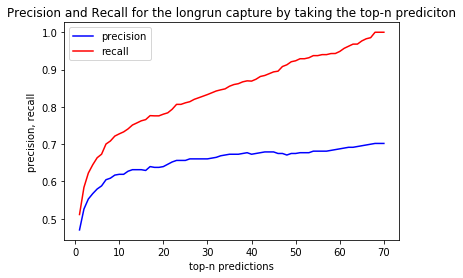

In [142]:
fig, ax = plt.subplots()
title = "Precision and Recall for the longrun capture by taking the top-n prediciton"
x_label = "top-n predictions"
y_label = "precision, recall"
dpi = 200
fname = title.replace(" ", "_")
y_lim = None
ax.plot(ns, precisions, '-b', label='precision')
ax.plot(ns, recalls, '-r', label='recall')
plt.title(title)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
if y_lim is not None:
    plt.ylim(y_lim[0], y_lim[1])
leg = ax.legend()
plt.savefig("./plots/"+fname, dpi=dpi)

Remarks: We can isolate pred that does not match any 

## Towards Realisitc Captures

### Be carefull with Fit Playstore Browse Map



1. **equilibrate actions** 

If an app counts 3 actions: a1, a2, a3 and another app countains only 1 action b1

we should have P(a1 or a2 or a3) = P(b1) = 0.5

In [951]:
# First, equilibrate actions. If an app counts 3 actions: a1, a2, a3 and another app countains only 1 action b1
# we should have P(a1 or a2 or a3) = P(b1) = 0.5
from collections import Counter
action_per_apps = Counter()
kept_actions = []
for action in all_actions:
    app, act = action.split("_")
    # skip force stop because anyway open trigers stop
    if act == "force-stop":
        continue 
    action_per_apps[app] += 1
    
    kept_actions.append(action)
apps_prob_vect = dict(action_per_apps)
total_app = len(c)
for app in apps_prob_vect:
    apps_prob_vect[app] = 1/total_app
apps_prob_vect

2. **Hight probability of popular application**

Application from this category should occur with a higher probability since they are more popular to trigger according to the study: 

"*Characterizing Smartwatch Usage In The Wild*" : Table 6 lists the most popular used apps in our dataset; they include `messengers`, `email clients`, `maps`, `activity trackers`, and `note taking` software.

<img src="./Results/popular_application.png">

In [962]:
apps = []
for app in apps_prob_vect:
    apps.append(app)

print("Application list:\n")
print("'" + "', '".join(apps) + "'")

Application list:

'Translate', 'DiabetesM', 'FitWorkout', 'Weather', 'PlayStore', 'Glide', 'Endomondo', 'FoursquareCityGuide', 'KeepNotes', 'Lifesum', 'SmokingLog', 'WashPost', 'MapMyRun', 'ChinaDaily', 'Running', 'Shazam', 'Fit', 'FITIVPlus', 'FitBreathe', 'Mobilis', 'SleepTracking', 'Citymapper', 'Bring', 'Krone', 'Outlook', 'FindMyPhone', 'Maps', 'DCLMRadio', 'Meduza', 'SalatTime', 'Telegram', 'HealthyRecipes', 'Spotify', 'Calm', 'Strava'


In [963]:
# Categories
messengers = ['Telegram', 'Glide']
emails = ['Outlook']
maps = ['Maps', 'Citymapper', 'FoursquareCityGuide']
fitness = ['FitWorkout', 'Fit', 'FITIVPlus', 'Endomondo', 'Strava', 'Running']
note_taking = ['Bring', 'KeepNotes']
health = ['Lifesum', 'SmokingLog', 'HealthyRecipes','DiabetesM']
banking = ['Mobilis']
media = ['ChinaDaily', 'Krone', 'WashPost', 'Meduza']
religious = ['DCLMRadio', 'SalatTime']
other = ['Translate', 'Weather', 'PlayStore', 'Shazam', 'FitBreathe', 'SleepTracking', 'FindMyPhone', 'Spotify', 'Calm']

In [964]:
popular = messengers + emails + fitness + note_taking

In [965]:
popular

['Telegram',
 'Glide',
 'Outlook',
 'FitWorkout',
 'Fit',
 'FITIVPlus',
 'Endomondo',
 'Strava',
 'Running',
 'Bring',
 'KeepNotes']

We want to derive the porbability vector of picking each apps. (The action within each apps will be equiprobable)

Let:

$p_{norm}$ be the probability of picking an action in the normal

$p_{pop}$ be the probability of picking an action in the popular set

$f$ be the factor at which the probability of picking an action in the popular is more likely to happen than the normal set

$N=|\{p_{norm}\}|$ be the cardinality of the action in the normal

$L=|\{p_{pop}\}|$ be the cardinality of action in the popular set



Then we have:

1. $\sum_{i}{p_i}=1$
2. $p_{pop} = f*p_{norm}$



With 1. and 2. : 

$$ L*f*p_{pop} + (N-L)*p_{norm} = 1 $$

Thus:

$p_{pop}=\frac{f}{N+L*(f-1)}$

$p_{norm}=\frac{1}{N+L*(f-1)}$



In [ ]:
f = 1.5  # multiplication factor. f more time to occur if in popular 
L = len(popular)
N = len(apps)

p_popular = f/(N + L * (f - 1)) 
p_normal = 1/(N + L * (f - 1)) 

# recompute probability vector
for app in apps_prob_vect:
    if app in popular: 
        apps_prob_vect[app] = p_popular
    else:
        apps_prob_vect[app] = p_normal

if sum(apps_prob_vect.values()) != 1.0:
    print("Error! Not a distribution probability. Please check the popular set")

cumul prob = 0


In [974]:
cumul = 0 
for app in apps_prob_vect:
    cumul += apps_prob_vect[app]
    apps_prob_vect[app] = cumul

In [975]:
apps_prob_vect

{'Translate': 0.024691358024691357,
 'DiabetesM': 0.04938271604938271,
 'FitWorkout': 0.08641975308641975,
 'Weather': 0.1111111111111111,
 'PlayStore': 0.13580246913580246,
 'Glide': 0.1728395061728395,
 'Endomondo': 0.20987654320987653,
 'FoursquareCityGuide': 0.2345679012345679,
 'KeepNotes': 0.2716049382716049,
 'Lifesum': 0.2962962962962963,
 'SmokingLog': 0.32098765432098764,
 'WashPost': 0.345679012345679,
 'MapMyRun': 0.37037037037037035,
 'ChinaDaily': 0.3950617283950617,
 'Running': 0.43209876543209874,
 'Shazam': 0.4567901234567901,
 'Fit': 0.49382716049382713,
 'FITIVPlus': 0.5308641975308641,
 'FitBreathe': 0.5555555555555555,
 'Mobilis': 0.5802469135802468,
 'SleepTracking': 0.6049382716049382,
 'Citymapper': 0.6296296296296295,
 'Bring': 0.6666666666666665,
 'Krone': 0.6913580246913579,
 'Outlook': 0.728395061728395,
 'FindMyPhone': 0.7530864197530863,
 'Maps': 0.7777777777777777,
 'DCLMRadio': 0.802469135802469,
 'Meduza': 0.8271604938271604,
 'SalatTime': 0.85185185185

In [1008]:
def pick_app_from_prob_vect(apps_prob_vect):
    r = random.random()
    for app in apps_prob_vect:
        if r < apps_prob_vect[app]:
            #print("r={}, app = {}".format(r, app))
            return app
    return app

3. **Time interval performed actions**

Should follow the same trend as the action utilisation 


<img src="./Results/user_temporal_usage.png">

<img src="./Results/user_interation_level.png" width="700">

Text(0, 0.5, 'Normalized User Interaction')

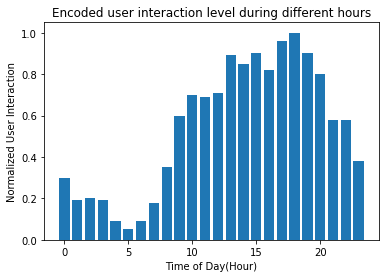

In [234]:
import time
t = time.time()
norm_user_interact_slot_10 = [0.3, 0.2, 0.2, 0.19, 0.1, 0.05, 0.1, 0.21, 0.42, 0.5, 0.6, 0.68, 0.7, 0.835, 0.84, 0.9, 0.85, 1, 0.96, 0.85, 0.8, 0.6, 0.61, 0.37]
norm_user_interact_slot_30 = [0.3, 0.19, 0.2, 0.19, 0.09, 0.05, 0.09, 0.18, 0.35, 0.6, 0.7, 0.69, 0.71, 0.89, 0.85, 0.9, 0.82, 0.96, 1, 0.9, 0.8, 0.58, 0.58, 0.38]
plt.bar(x = np.arange(24), height=norm_user_interact_slot_30)
plt.title("Encoded user interaction level during different hours")
plt.xlabel("Time of Day(Hour)")
plt.ylabel("Normalized User Interaction")

Text(0, 0.5, 'Normalized action performed')

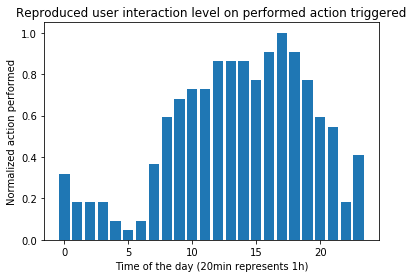

In [235]:
PATH = "./data/huawei/longrun/user-interaction-pattern-2/"
GROUND_TRUTH_PATH = PATH + "ground-truth/"
gt_path_content = sorted(glob.glob(GROUND_TRUTH_PATH + '*.log', recursive=True))

gt_content = read_longrun_log_files(gt_path_content)

slots_action_count = []
for c in gt_content:
    count = 0
    for a in gt_content[c]:
        if "open" in a[1]:

            count += 1
    slots_action_count.append(count)

slots_action_count = np.array(slots_action_count)  
slots_action_count = slots_action_count/np.max(slots_action_count)
plt.bar(x = np.arange(24), height=slots_action_count)
plt.title("Reproduced user interaction level on performed action triggered")
plt.xlabel("Time of the day (20min represents 1h)")
plt.ylabel("Normalized action performed")
#slots_action_count

Text(0, 0.5, 'Normalized action performed')

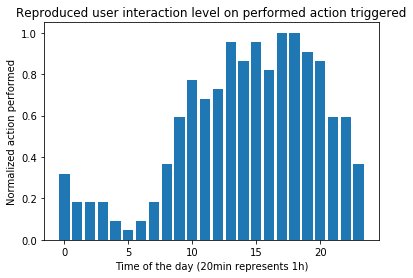

In [236]:
PATH = "./data/huawei/longrun/user-interaction-pattern-1/"
GROUND_TRUTH_PATH = PATH + "ground-truth/"
gt_path_content = sorted(glob.glob(GROUND_TRUTH_PATH + '*.log', recursive=True))

gt_content = read_longrun_log_files(gt_path_content)

slots_action_count = []
for c in gt_content:
    count = 0
    for a in gt_content[c]:
        if "open" in a[1]:

            count += 1
    slots_action_count.append(count)

slots_action_count = np.array(slots_action_count)  
slots_action_count = slots_action_count/np.max(slots_action_count)
plt.bar(x = np.arange(24), height=slots_action_count)
plt.title("Reproduced user interaction level on performed action triggered")
plt.xlabel("Time of the day (20min represents 1h)")
plt.ylabel("Normalized action performed")

In [51]:
gt_content['longrun_user_interact_pattern_20-04-09_14-11-37_slot-0'][2]


['298.1', 'Shazam_open']

TODO:

1. Consider cutting only if not received any packet with length l > n after t time for different n and t
2. Train classifer for wrong classified allows to increase accuracy (But decrease Recall)
    1. On proba output: Correct Pred -> 1 / Wrong Pred -> 0 (Better I guess)
    2. On features Vec: Use NoApp_NoAction as another class 
